In [ ]:
# Import libraries and modules
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import datasets
from tensorflow import keras
from keras import layers
import numpy as np
import random
from keras import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
# Load cifar10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# Create dataset object from tensors and perform preprocessing
# Preprocessing steps involved are:
## cast tensors to float
## normalize images to values between 0 and 1
## one-hot encode labels
## zip input and labels
## batch dataset
## shuffle dataset
 
train_im = tf.data.Dataset.from_tensor_slices(x_train)
train_la = tf.data.Dataset.from_tensor_slices(y_train)

train_im = train_im.map(lambda img : tf.cast(img, tf.float32))
train_im = train_im.map(lambda img : (img - tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img)))
train_la = train_la.map(lambda t : tf.one_hot(t,10))
train_la = train_la.map(lambda t : tf.cast(t, tf.float32))
train_la = train_la.map(lambda t : tf.squeeze(t))


tr_ds = tf.data.Dataset.zip((train_im, train_la))


tr_ds = tr_ds.batch(64)


#same for testing stuff

test_im = tf.data.Dataset.from_tensor_slices(x_test)
test_la = tf.data.Dataset.from_tensor_slices(y_test)

test_im = test_im.map(lambda img : tf.cast(img, tf.float32))
test_im = test_im.map(lambda img : (img - tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img)))
test_la = test_la.map(lambda t : tf.one_hot(t, 10))
test_la = test_la.map(lambda t : tf.cast(t, tf.float32))
test_la = test_la.map(lambda t : tf.squeeze(t))

te_ds = tf.data.Dataset.zip((test_im, test_la))

te_ds = te_ds.batch(64)



In [ ]:
# We use a dynamic learning rate which decays exponantially
# As an optimiser we use adam

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 
                                                    5000, 
                                                    0.97,
                                                    staircase=True)
opt = tf.optimizers.Adam(learning_rate=lr)

In [ ]:
# The model consists of 5 convolutional layers with 64 filters each and relu as the activation function
# we regularise the kernels and biases with L1L2 regularisation.
# Before each Convolutional Layer we normalise the input batch
# pooling and dropout are performed thrice
# A dense layer functions as the output layer

from keras import Model

class Model(Model):
  
  def __init__(self):
    super(Model, self).__init__()

    self.features = 64

    self.batch_norm1 = keras.layers.BatchNormalization()
    
    self.conv_1 = Conv2D(filters=32, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         activation='relu', 
                         padding='same',
                         kernel_regularizer=tf.keras.regularizers.L1L2,
                         bias_regularizer=tf.keras.regularizers.L1L2
                         )
    
    self.mpool_1 = tf.keras.layers.MaxPooling2D()

    self.batch_norm2 = keras.layers.BatchNormalization()

    self.conv_2 = Conv2D(filters=32, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         activation='relu', 
                         padding='same',
                         kernel_regularizer=tf.keras.regularizers.L1L2,
                         bias_regularizer=tf.keras.regularizers.L1L2
                         )

    self.batch_norm3 = keras.layers.BatchNormalization()

    self.dropout_1 = Dropout(0.2)


    self.conv_3 = Conv2D(filters=self.features, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         activation='relu', 
                         padding='same',
                         kernel_regularizer=tf.keras.regularizers.L1L2,
                         bias_regularizer=tf.keras.regularizers.L1L2)
    
    self.batch_norm4 = keras.layers.BatchNormalization()

   
    self.conv_4 = Conv2D(filters=self.features, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         activation='relu', 
                         padding='same',
                         kernel_regularizer=tf.keras.regularizers.L1L2,
                         bias_regularizer=tf.keras.regularizers.L1L2)
    self.mpool_4 = tf.keras.layers.MaxPooling2D()
      
    self.batch_norm5 = keras.layers.BatchNormalization()

    self.dropout_2 = Dropout(0.2)


    self.conv_5 = Conv2D(filters=self.features, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         activation='relu', 
                         padding='same',
                         kernel_regularizer=tf.keras.regularizers.L1L2,
                         bias_regularizer=tf.keras.regularizers.L1L2)
    self.mpool_5 = tf.keras.layers.MaxPool2D()

    self.dropout_3 = Dropout(0.2)

    self.flat = Flatten()

    self.output_layer = Dense(10, 
                        activation='softmax')
    
  def call(self, x, training=True):
    x = self.batch_norm1(x, training)
    x = self.conv_1(x)
    x = self.mpool_1(x)
    x = self.batch_norm2(x, training)
    x = self.conv_2(x)
    x = self.dropout_1(x, training)
    x = self.batch_norm3(x, training)
    x = self.conv_3(x)
    x = self.batch_norm4(x, training)
    x = self.conv_4(x)
    x = self.mpool_4(x)
    x = self.dropout_2(x, training)
    x = self.batch_norm5(x, training)
    x = self.conv_5(x)
    x = self.mpool_5(x)

    x = self.dropout_3(x, training)
    x = self.flat(x)
    x = self.output_layer(x)

    return x 


In [ ]:
# Training method returns mean loss and mean accuracy of the batch

def train(model, input, target, loss_f, optimizer): 
  with tf.GradientTape() as tape: 
    prediction = model(input)
    loss = loss_f(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  acc = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)


  return np.mean(loss.numpy()), np.mean(acc)


# Test method takes in whole test dataset and returns mean loss and mean accuracy on the whole test data
def test(model, test_data, loss_f): 
  test_acc = []
  test_loss = []

  for (input, target) in test_data: 
    prediction = model(input, training=False)
    loss = loss_f(target, prediction)
    loss = np.mean(loss.numpy())
    acc = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_loss.append(loss)
    test_acc.append(np.mean(acc))
  

  fin_loss = np.mean(np.array(test_loss))
  fin_acc = np.mean(test_acc)

  return fin_loss, fin_acc

In [ ]:
# Define additional hyperparameters

# Loss is categorical crossentropy
# The model will train for 30 epochs

tf.keras.backend.clear_session()

num_epochs = 30
learning_rate = lr
running_average_factor = 0.95


cross_entropy_loss = tf.keras.losses.categorical_crossentropy

optimizer = opt

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [ ]:
# Custom training loop
# Each epoch the model will learn on the shuffled and batched training data and will then evaluate the training step on the whole test dataset

model = Model()
for epoch in range(num_epochs):
  print('Epoch:__' + str(epoch))

  tr_ds = tr_ds.shuffle(buffer_size=128).prefetch(2)
  te_ds = te_ds.shuffle(buffer_size=128).prefetch(2)


  running_average = 0
  batch_acc = []
  for (input, target) in tr_ds: 
    train_l, train_acc = train(model, input, target, cross_entropy_loss, optimizer)
    running_average = (running_average_factor * running_average) + (1 - running_average_factor) * train_l
    batch_acc.append(train_acc)

  train_losses.append(running_average)
  train_accuracies.append(np.mean(batch_acc))
  print('Train Accuracy: ', train_accuracies[-1])

  #testing
  test_loss, test_accu = test(model, te_ds, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accu)
  print('Test Accuracy: ', test_accu)
  print()


Epoch:__0
Train Accuracy:  0.4946251598465473
Test Accuracy:  0.6354498407643312

Epoch:__1
Train Accuracy:  0.6596467391304348
Test Accuracy:  0.7171576433121019

Epoch:__2
Train Accuracy:  0.715093510230179
Test Accuracy:  0.7477109872611465

Epoch:__3
Train Accuracy:  0.7461836636828645
Test Accuracy:  0.7594546178343949

Epoch:__4
Train Accuracy:  0.7682624680306905
Test Accuracy:  0.7813495222929936

Epoch:__5
Train Accuracy:  0.7831481777493606
Test Accuracy:  0.7899084394904459

Epoch:__6
Train Accuracy:  0.7966951726342711
Test Accuracy:  0.7945859872611465

Epoch:__7
Train Accuracy:  0.8105019181585678
Test Accuracy:  0.8065286624203821

Epoch:__8
Train Accuracy:  0.8211716751918159
Test Accuracy:  0.8039410828025477

Epoch:__9
Train Accuracy:  0.8266464194373402
Test Accuracy:  0.8069267515923567

Epoch:__10
Train Accuracy:  0.8354979219948849
Test Accuracy:  0.802547770700637

Epoch:__11
Train Accuracy:  0.8397338554987213
Test Accuracy:  0.8161823248407644

Epoch:__12
Train

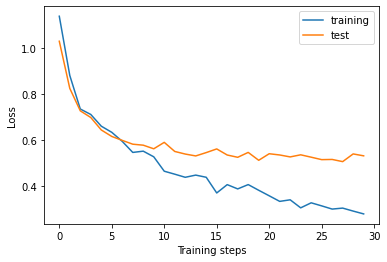

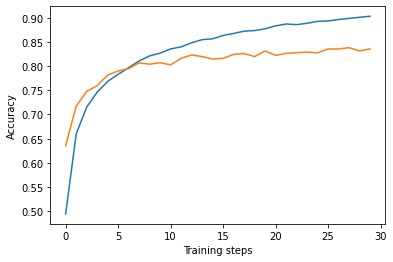

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()